In [1]:
import torch
import torch.nn as nn
import cv2
from model_util import convbnrelu,image_CBR_2,image_CBR_3,depth_CBR_2,depth_CBR_3,dec_CBS3,dec_CBS2,FullyConnected
import numpy as np
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
def read_image(path):
    img = cv2.imread(path)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img

def load_sparse_depth(input_sparse_depth_fp):
    input_sparse_depth = np.array(Image.open(input_sparse_depth_fp), dtype=np.float32) / 256.0
    input_sparse_depth[input_sparse_depth <= 0] = 0.0
    return input_sparse_depth


In [32]:
%pwd

'c:\\Users\\kagad\\Vishal\\Fusion_net'

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),])
transform_radar = transforms.Compose([
    transforms.ToTensor(),])

In [4]:
import os
import glob
class TrainDataLoader(Dataset):
    def __init__(self,
                 image_paths,
                 radar_paths,
                 radar_pcd_paths,
                 ground_truth_paths,transform):
        
        self.image_paths = glob.glob(os.path.join(image_paths, '*.*'))
        self.radar_paths = glob.glob(os.path.join(radar_paths, '*.*'))
        self.ground_truth_paths = glob.glob(os.path.join(ground_truth_paths, '*.*'))
        self.radar_pcd_paths = glob.glob(os.path.join(radar_pcd_paths, '*.*'))

        self.n_sample = len(self.image_paths )

        assert self.n_sample == len(self.ground_truth_paths)
        assert self.n_sample == len(self.radar_paths )
        assert self.n_sample == len(self.radar_pcd_paths)
        
        self.transform = transform
        self.transform_radar = transform_radar

    def process_radar_points(self,radar_points):
        '''
        Arg(s)
        radar_points (torch.Tensor): 1 x 1 x N x 3 (batch, channel, number of radar points, (x, y, z))

        Return(s)
        processed_points (torch.Tensor): 1 x 1 x 600 x 3 (batch, channel, 600 radar points, (x, y, z))
        '''
        # Set the target number of radar points
        target_num_points = 600
        
        # Get the current number of radar points
        num_points = radar_points.shape[0]

        if num_points > target_num_points:
            # Truncate to the first 600 points if there are more than 600
            radar_points = radar_points[:target_num_points, :]
        elif num_points < target_num_points:
            # Pad with zeros if there are fewer than 600 points
            padding = np.zeros((target_num_points - num_points, 3))
            radar_points = np.concatenate((radar_points, padding), axis=0)  

        return radar_points


    def __len__(self):
        return self.n_sample

    def __getitem__(self,index):

        image = read_image(self.image_paths[index])/255

        radar_img = load_sparse_depth(self.radar_paths[index])
        radar_img = radar_img/radar_img.max()

        ground_truth = load_sparse_depth(self.ground_truth_paths[index])
        ground_truth = ground_truth/ground_truth.max()

        radar_points = np.load(self.radar_pcd_paths[index])
        if radar_points.ndim == 1:
            radar_points = np.expand_dims(radar_points, axis=0)
        radar_points = self.process_radar_points(radar_points) 

        if self.transform:
            image = self.transform(image)
            radar_img = self.transform(radar_img)
            ground_truth = self.transform(ground_truth)
            radar_points = self.transform_radar(radar_points)
        image, radar_img,radar_points, ground_truth = [T.float() for T in [image, radar_img,radar_points, ground_truth]]

        
        return image, radar_img,radar_points, ground_truth

In [5]:
image_folder = r"C:\Users\kagad\Vishal\Fusion_net\data\image"
radar_path = r"C:\Users\kagad\Vishal\Fusion_net\data\radar_png"
gt_path = r"C:\Users\kagad\Vishal\Fusion_net\data\gt_interp"
radar_pcd_path = r"C:\Users\kagad\Vishal\Fusion_net\data\radar"

In [6]:
dataset = TrainDataLoader(image_folder,radar_path,radar_pcd_path,gt_path,transform=transform)

In [7]:
train_loader = torch.utils.data.DataLoader(dataset,batch_size=1, shuffle=True,num_workers=0)

In [8]:
img,rad,radar_points,gt = next(iter(train_loader))

c:\Users\kagad\anaconda\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


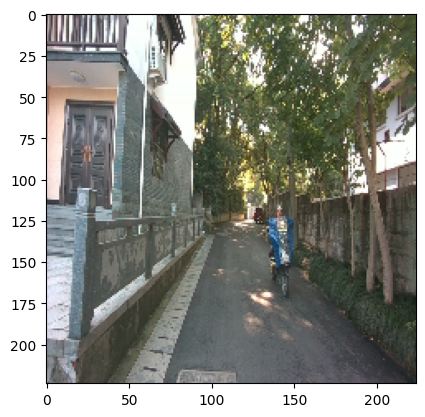

In [9]:
plt.imshow(img[0].permute(1,2,0).detach().numpy())

In [10]:
class depth_encoder(nn.Module):
    def __init__(self,in_channels = 1,out_channels = [64,128,256,512,512]):
        super().__init__()
        
        self.layer_1 = depth_CBR_2(in_channels= in_channels,out_channels= out_channels[0])
        self.layer_2 = depth_CBR_2(in_channels= out_channels[0],out_channels= out_channels[1])
        self.layer_3 = depth_CBR_3(in_channels= out_channels[1],out_channels= out_channels[2])
        self.layer_4 = depth_CBR_3(in_channels= out_channels[2],out_channels= out_channels[3])
        self.layer_5 = depth_CBR_3(in_channels= out_channels[3],out_channels= out_channels[3])


    def forward(self,x):
        skip_latent = []

        x, skip = self.layer_1(x)
        skip_latent.append(skip)
        x, skip = self.layer_2(x)
        skip_latent.append(skip)
        x, skip = self.layer_3(x)
        skip_latent.append(skip)
        x, skip = self.layer_4(x)
        skip_latent.append(skip)
        _, skip = self.layer_5(x)
        skip_latent.append(skip)

        return skip_latent

In [11]:
class image_encoder(nn.Module):
    def __init__(self,in_channels = 3,out_channels = [64,128,256,512,512]):
        super(image_encoder,self).__init__()
        self.out_channels = out_channels

        self.layer_1 = image_CBR_2(in_channels= in_channels,out_channels= out_channels[0])
        self.layer_2 = image_CBR_2(in_channels= out_channels[0],out_channels= out_channels[1])

        self.layer_3 = image_CBR_3(in_channels= out_channels[1],out_channels= out_channels[2])
        self.layer_4 = image_CBR_3(in_channels= out_channels[2],out_channels= out_channels[3])
        self.layer_5 = image_CBR_3(in_channels= out_channels[3],out_channels= out_channels[3])

    def forward(self,x,skip_con):
        indices_list = list()
        x,indices = self.layer_1(x,skip_con[0])
        indices_list.append(indices)
        x,indices  = self.layer_2(x,skip_con[1])
        indices_list.append(indices)
        x,indices  = self.layer_3(x,skip_con[2])
        indices_list.append(indices)
        x,indices  = self.layer_4(x,skip_con[3])
        indices_list.append(indices)
        x,indices  = self.layer_5(x,skip_con[4])
        indices_list.append(indices)

        return x,indices_list



In [12]:
class FullyConnectedEncoder(nn.Module):

    def __init__(self,
                 input_channels =3,
                 n_neuron = [64,128,256,512,512]
                 ):
        super(FullyConnectedEncoder,self).__init__()
        self.n_neuron = n_neuron
        self.fc_layer = nn.ModuleList([FullyConnected(in_features=input_channels *600, out_features = n_neuron[0]),
                                  FullyConnected(in_features=n_neuron[0],out_features = n_neuron[1]),
                                  FullyConnected(in_features=n_neuron[1],out_features = n_neuron[2]),
                                  FullyConnected(in_features=n_neuron[2],out_features = n_neuron[3]),
                                  FullyConnected(in_features=n_neuron[3],out_features = n_neuron[4])])
        
    def forward(self,x):
        fully_skip_connect = list()
        x = x.view(1,-1)
        for layer in self.fc_layer:
            x = layer(x)
        return x

In [13]:
depth_encoder = depth_encoder()
image_encoder = image_encoder()
radar_encoder = FullyConnectedEncoder()

In [16]:
radar_output = radar_encoder(radar_points)
skip = depth_encoder(rad)
image_lat,indices_list = image_encoder(img,skip)

In [21]:
radar_output = radar_output.unsqueeze(2).unsqueeze(3).expand(-1,-1,7,7)

In [23]:
output = image_lat+radar_output

In [26]:
class decoder(nn.Module):
    def __init__(self,in_channels=512, out_channels=image_encoder.out_channels[::-1][1:]):
        super().__init__()
        self.dec_layer1 = dec_CBS3(in_channels=in_channels,out_channels=out_channels[0])
        self.dec_layer2 = dec_CBS3(in_channels=out_channels[0],out_channels=out_channels[1])
        self.dec_layer3 = dec_CBS2(in_channels=out_channels[1],out_channels=out_channels[2])
        self.dec_layer4 = dec_CBS2(in_channels=out_channels[2],out_channels=out_channels[3],dropout=False)
        self.dec_layer5 = dec_CBS2(in_channels=out_channels[3],out_channels=1,dropout=False)

    def forward(self,x,indices):
        x =  self.dec_layer1(x,indices = indices[4],output_size= indices[3].shape) # 14*14
        x =  self.dec_layer2(x,indices = indices[3],output_size= torch.Size([1,256,28,28])) # 28*28
        x =  self.dec_layer3(x,indices = indices[2],output_size= torch.Size([1,128,56,56])) # 56*56
        x =  self.dec_layer4(x,indices = indices[1],output_size= torch.Size([1,64,112,112])) # 112*112
        x =  self.dec_layer5(x,indices = indices[0],output_size= torch.Size([1,1,224,224])) # 224*224

        return x

In [27]:
fusion_decoder = decoder()

In [28]:
depth_map = fusion_decoder(output,indices_list)

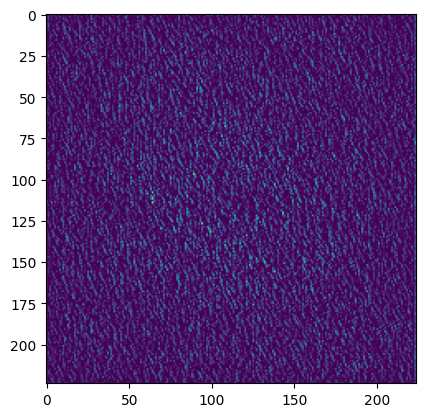

In [29]:
plt.imshow(depth_map[0].permute(1,2,0).detach().numpy())